# Continuous RL Model

## Purpose: 
Build an RL model which can handle a continuous decision-space, requires generalization across choice spaces. 

I.e., a continuous RL model assumes having a model of choices that are connected (latent state inference). 

# Load packages

In [3]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
from tqdm import tqdm # progress bar

# Load data

In [5]:
base_dir = os.getcwd()
data_dir = base_dir + '/Data'
df = pd.read_csv(data_dir + '/continuous_TG.csv')
display(df.head(5))

# soe = second order expectation (due to multiplier) 
# fair = how much would be fair to give back 
# soc1 = descriptive social norm (how much do you think other people would give) 
# soc2 = injunctive social norm (how much do you think people would find fair) 

,sub,investment,multiplier,returned,soe,fair,soc1,soc2
0,122,3,4,2,2,2.0,3.0,2.0
1,122,10,4,24,20,20.0,20.0,20.0
2,122,3,4,2,2,2.0,3.0,2.0
3,122,2,4,0,0,0.0,0.0,0.0
4,122,6,2,8,10,4.0,4.0,4.0


# Define inequality aversion model for TG

1. Player A starts out with $10 

2. Player A offers X (out of $10) to Player B (keeping $10- x)

3. X is multiplied by multiplier (x4 often)

4. Player B has full control over X*multiplier and sends split back 

5. Final outcomes: Player A (kept $10 - x and receives some back from B), Player B (only keeps split) 

## How the model works

if dis_inequality: 
    U(choice) = payoff - alpha*dis_inequality 
else: # adv_inequality
    U(choice) = payoff - beta*adv_inequality

In [7]:
def inequality_aversion(investment, multiplier, alpha, beta):
    # Inputs:
    #       investment: single TG offer to participant
    #       multiplier: amount investment is multipled by
    #       alpha: single value alpha represents 'envy' of being poorer
    #       beta: single value beta represents 'guilt' of being richer
    # Outputs:
    #       trial_df: dataframe with all values needed
        
    ## Inequity aversion model
    amount_received = investment*multiplier

    # Get all possible combinations of options participant can return
    trial_df = pd.DataFrame({'player_A': np.arange(0, amount_received+1, step = 1), # arange indexing
                            'player_B': np.arange(amount_received, -1, step = -1)}) # way arange indexes requires -1
    trial_df['player_A_kept'] = 10 - investment # accounting for what they kept
    trial_df['inequalities'] = trial_df['player_B'] - (trial_df['player_A'] + trial_df['player_A_kept'])

    # Loop through 
    utilities = []
    for index, row in trial_df.iterrows():  
        if row['inequalities'] >= 0: # advantageous inequality
            utility = row['player_B'] - abs((beta*row['inequalities']))
            utilities.append(utility)
        else: # disadvantageous inequality
            utility = row['player_B'] - abs((alpha*row['inequalities'])) # need to account for the sign 
            utilities.append(utility)

    # Add
    trial_df['utilities'] = utilities
    trial_df['alpha'] = alpha
    trial_df['beta'] = beta
            
    return trial_df
#inequality_aversion(investment = 3, multiplier = 4, alpha = .2, beta = .9)

,player_A,player_B,player_A_kept,inequalities,utilities,alpha,beta
0,0,12,7,5,7.5,0.2,0.9
1,1,11,7,3,8.3,0.2,0.9
2,2,10,7,1,9.1,0.2,0.9
3,3,9,7,-1,8.8,0.2,0.9
4,4,8,7,-3,7.4,0.2,0.9
5,5,7,7,-5,6.0,0.2,0.9
6,6,6,7,-7,4.6,0.2,0.9
7,7,5,7,-9,3.2,0.2,0.9
8,8,4,7,-11,1.8,0.2,0.9
9,9,3,7,-13,0.4,0.2,0.9


## Plot for confirmation

[Text(0.5, 1.0, 'alpha = 0.10, beta = 0.60')]

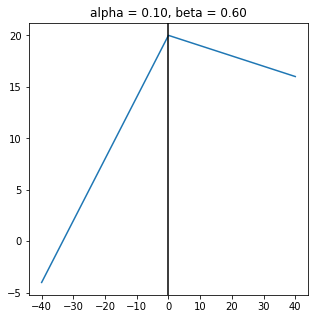

In [22]:
test = inequality_aversion(investment = 10, multiplier = 4, alpha = .1, beta = 0.6)

fig, ax = plt.subplots(nrows = 1, ncols =1, figsize = [5,5])
plt.plot(test['inequalities'], test['utilities'])
plt.axvline(x=0, color = 'black')
ax.set(title = 'alpha = %.2f, beta = %.2f'%(test['alpha'][0], test['beta'][0]))

# Going beyond inequality aversion model

/Users/dendrite/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/dendrite/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


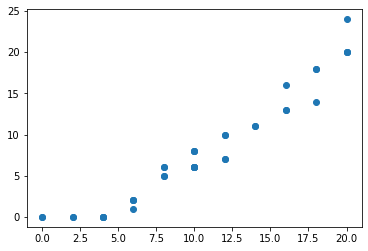

In [38]:
df_sub1 = df[(df['sub'] == 122) & (df['multiplier'] == 4)]
df_sub1['player_A_final'] = (10 - df_sub1['investment']) + df_sub1['returned']
df_sub1['player_B_final'] = df_sub1['investment']*df_sub1['multiplier'] - df_sub1['returned']

plt.scatter(df_sub1['investment']/2*4, df_sub1['returned'])
#plt.axvline(x=0, color = 'black')

# To do: 

1. Can we account for other sources of utility? E.g., reciprocity (or is this only accounted for by inequality) 
2. Generalize what we've learned across items (similar to Lotte pain v gain) 
3. Adapt for Amrita's dataset perhaps (we could only consider the first 5 trials for example) 

## OLD (have not updated yet!) 

# Define model fitting functions

In [16]:
def softmax(utilities, beta):
    # Inputs:
    #       utilities: value of accepting or rejecting the offer, in that order 
    #       beta: inverse temperature, also known as exploitation parameter
    # Outputs:
    #       choice_probs: model's predicted probability of accept or reject
    #       choice: model's single response to the offer, accept (0) or reject (1)

    # Numerator represents value of utility of single choice
    numerator = np.exp(np.multiply(utilities, beta))

    # Denominator represents sum of total value of utilities
    denominator = np.sum(np.exp(np.multiply(utilities, beta)))
    
    # Outputs
    choice_probs = numerator / denominator
    
    # Choice
    #choice = np.where(utilities == np.random.choice(utilities, p = choice_probs)) # index choice based on choice_probs
    #if (len(choice[0])) == 1: 
    #    choice = choice[0][0]
    #else: 
    #    choice = np.random.choice(choice[0])
    
    return choice_probs #, choice
softmax([5,5], beta = .1)

array([0.5, 0.5])

In [18]:
def getModelLikelihood(params, data):
    # Inputs:
    #       params: inequality aversion (alpha) and inverse temperature (beta), in that order
    #       data: single participant's Ultimatum Game data, requires only offer and choice
    # Outputs:
    #       neg_log_likelihood: negative log likelihood of the data conditional on parameters
    
    # Define parameters    
    alpha = params[0]
    beta = params[1]
    neg_log_likelihood = 0.
    
    # Loop through trials
    for row in data:                                       # index and row; less intuitive but faster than: for index, row in data.iterrows():
        offer = row[6]                                     # row['offer']
        choice = row[4]                                    # row['choice']
        utilities = inequality_aversion(offer, alpha)
        choice_probs = softmax(utilities, beta)
        choice_probs = softmax(utilities, beta)            # don't need pred_choice
        neg_log_likelihood += np.log(choice_probs[choice]) # choice must be 0 or 1 for this index to work
        
    if (-neg_log_likelihood == -np.inf): return 10000      # prevent extremely large neg_log_likelihoods 
    else: return -neg_log_likelihood
            
getModelLikelihood(params = [.4, .1], data = df_sub2.values)

6.612632763082386

# Model Fit Procedure

In [19]:
# make dataframe to store results
df_results = pd.DataFrame(columns = ['sub', 'alpha', 'beta', 'log_lik'])

for sub, df_sub in tqdm(df.groupby('sub')): # groupby object with progress bar
    
    print('fitting', sub)
    [best_ll, best_params] = [-np.inf, None] # storing best log likelihood and best params
    
    for attempt in range(30): # range (30)
        start_point = [np.random.rand(), np.random.rand()] # alpha, beta
        res = scipy.optimize.fmin(getModelLikelihood, start_point, args=(df_sub.values, ), full_output=True,maxfun=10000)
        [params, ll] = [res[0], -1*res[1]]
        
        if (ll > best_ll): # updates best_params, best_ll
            best_ll = ll
            best_params = params
        
    # Create df to store results for sub
    df_sub_params = pd.DataFrame({'sub': sub, 
                                 'alpha': best_params[0], 
                                 'beta': best_params[1], 
                                 'log_lik': best_ll}, index = [sub])

    # Append
    df_results = df_results.append(df_sub_params)
    
    # Save results just in case of crash
    df_results.to_csv(data_dir + '/study1_ug_fit_temp.csv')

  0%|                                                                                                                                              | 0/364 [00:00<?, ?it/s]c:\users\jheffner\appdata\local\continuum\anaconda3\envs\py37_env\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
c:\users\jheffner\appdata\local\continuum\anaconda3\envs\py37_env\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
c:\users\jheffner\appdata\local\continuum\anaconda3\envs\py37_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


fitting 1
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 64
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization term

  0%|▎                                                                                                                                     | 1/364 [00:02<13:01,  2.15s/it]

fitting 2
Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 6.392668
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 30
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 40
         Function evaluations: 77
Optimization terminated 

  1%|▋                                                                                                                                     | 2/364 [00:04<12:57,  2.15s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 30
         Function evaluations: 59
Optimization terminated successfully.
         Current function value: 6.392668
         Iterations: 38
         Function evaluations: 74
fitting 3
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization termin

  1%|█                                                                                                                                     | 3/364 [00:06<12:48,  2.13s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
fitting 4
Optimization terminated successfully.
         Current function value: 7.950944
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 30
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 33
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 56
         Function evaluations: 106
Optimization terminat

  1%|█▍                                                                                                                                    | 4/364 [00:08<13:35,  2.27s/it]

Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 7.950944
         Iterations: 47
         Function evaluations: 89
fitting 5
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 152
         Function evaluations: 300
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 105
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 95
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 121
         Function evaluations: 237
Optimization term

  1%|█▊                                                                                                                                    | 5/364 [00:15<21:39,  3.62s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 106
         Function evaluations: 210
fitting 6
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 120
Optimizati

  2%|██▏                                                                                                                                   | 6/364 [00:18<20:54,  3.50s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 116
fitting 7
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 148
Optimizati

  2%|██▌                                                                                                                                   | 7/364 [00:22<21:19,  3.58s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 140
fitting 8
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 147
Optimization te

  2%|██▉                                                                                                                                   | 8/364 [00:24<18:43,  3.16s/it]

fitting 9
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 77
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 76
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 74
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 130
Optimizatio

  2%|███▎                                                                                                                                  | 9/364 [00:28<19:39,  3.32s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 107
fitting 10
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization 

  3%|███▋                                                                                                                                 | 10/364 [00:30<17:40,  3.00s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
fitting 11
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 80
Optimization t

  3%|████                                                                                                                                 | 11/364 [00:33<16:10,  2.75s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 27
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 12
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization ter

  3%|████▍                                                                                                                                | 12/364 [00:35<15:00,  2.56s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
fitting 14
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 79
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 124
Optimizati

  4%|████▊                                                                                                                                | 13/364 [00:46<31:07,  5.32s/it]


         Current function value: -0.000000
         Iterations: 74
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 136
fitting 15
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 32
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Cur

  4%|█████                                                                                                                                | 14/364 [00:49<25:26,  4.36s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 67
fitting 16
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 79
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 97
Optimization

  4%|█████▍                                                                                                                               | 15/364 [00:52<23:45,  4.09s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 101
fitting 18
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 100
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 113
         Function evaluations: 227
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 151
         Function evaluations: 297
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 130
         Function evaluations: 257
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 99
         Function evaluations: 202
Optimizati

  4%|█████▊                                                                                                                               | 16/364 [00:58<27:24,  4.73s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 137
         Function evaluations: 273
fitting 19
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 34
         Function evaluations: 63
Optimization termin

  5%|██████▏                                                                                                                              | 17/364 [01:00<22:37,  3.91s/it]

Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 22
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 40
         Function evaluations: 75
fitting 20
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 34
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 36
         Function evaluations: 69
Optimization terminated

  5%|██████▌                                                                                                                              | 18/364 [01:02<19:38,  3.41s/it]

Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 56
         Function evaluations: 106
fitting 21
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 75
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 118
Optimization

  5%|██████▉                                                                                                                              | 19/364 [01:06<19:15,  3.35s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 74
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 98
fitting 22
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 81
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 131
Optimizati

  5%|███████▎                                                                                                                             | 20/364 [01:10<20:05,  3.50s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 70
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 131
fitting 23
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 115
         Function evaluations: 242
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 120
         Function evaluations: 265
Optimiz

  6%|███████▋                                                                                                                             | 21/364 [01:15<22:58,  4.02s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 125
fitting 24
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 27
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization te

  6%|████████                                                                                                                             | 22/364 [01:17<19:34,  3.43s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
fitting 25
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 83
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 122
Optimizati

  6%|████████▍                                                                                                                            | 23/364 [01:20<19:09,  3.37s/it]


         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 105
fitting 26
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 81
Optimization terminated successfully.
         Curr

  7%|████████▊                                                                                                                            | 24/364 [01:22<17:13,  3.04s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 30
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
fitting 27
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization ter

  7%|█████████▏                                                                                                                           | 25/364 [01:24<15:30,  2.75s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 102
fitting 28
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 121
Optimizatio

  7%|█████████▌                                                                                                                           | 26/364 [01:28<17:06,  3.04s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 138
fitting 29
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 79
Optimization t

  7%|█████████▊                                                                                                                           | 27/364 [01:30<15:18,  2.73s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
fitting 30
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 114
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 114
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 104
         Function evaluations: 205
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 130
         Function evaluations: 261
Optimization

  8%|██████████▏                                                                                                                          | 28/364 [01:37<21:37,  3.86s/it]

fitting 31
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 124
Optimizati

  8%|██████████▌                                                                                                                          | 29/364 [01:40<20:20,  3.64s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 145
fitting 32
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 119
Optimizat

  8%|██████████▉                                                                                                                          | 30/364 [01:43<20:19,  3.65s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 160
fitting 33
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 89
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 150
         Function evaluations: 299
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 90
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 145
         Function evaluations: 289
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 123
         Function evaluations: 249
Optimizatio

  9%|███████████▎                                                                                                                         | 31/364 [01:49<24:21,  4.39s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 106
         Function evaluations: 212
fitting 34
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 145
Optimizat

  9%|███████████▋                                                                                                                         | 32/364 [01:53<23:17,  4.21s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 117
fitting 36
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 124
Optimizat

  9%|████████████                                                                                                                         | 33/364 [01:57<21:56,  3.98s/it]


         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 137
fitting 37
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 36
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 112
Optimization terminated successfully.
        

  9%|████████████▍                                                                                                                        | 34/364 [02:00<20:47,  3.78s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 112
fitting 38
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 34
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 130
Optimizati

 10%|████████████▊                                                                                                                        | 35/364 [02:03<20:08,  3.67s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 96
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 108
fitting 39
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 153
         Function evaluations: 299
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 126
         Function evaluations: 254
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 153
         Function evaluations: 304
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 112
         Function evaluations: 227
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 112
         Function evaluations: 226
Optimizat

 10%|█████████████▏                                                                                                                       | 36/364 [02:11<26:07,  4.78s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 146
         Function evaluations: 293
fitting 40
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 142
Optimizat

 10%|█████████████▌                                                                                                                       | 37/364 [02:15<24:49,  4.56s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 134
fitting 41
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 131
         Function evaluations: 257
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 130
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 133
         Function evaluations: 269
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 118
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 128
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 127
         Function evaluations: 256
Optimizat

 10%|█████████████▉                                                                                                                       | 38/364 [02:22<29:26,  5.42s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 175
         Function evaluations: 352
fitting 42
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 123
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 124
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 123
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 117
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 138
         Function evaluations: 277
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 108
         Function evaluations: 214
Optimizat

 11%|██████████████▎                                                                                                                      | 39/364 [02:29<31:33,  5.83s/it]

fitting 43
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 63
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 36
         Function evaluations: 95
Optimization ter

 11%|██████████████▌                                                                                                                      | 40/364 [02:31<25:46,  4.77s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 114
fitting 44
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 67
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 110
Optimization 

 11%|██████████████▉                                                                                                                      | 41/364 [02:34<21:52,  4.06s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 76
fitting 45
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 81
Optimization ter

 12%|███████████████▎                                                                                                                     | 42/364 [02:36<18:55,  3.53s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 46
Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 63
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 45
         Function evaluations: 88
Optimization terminat

 12%|███████████████▋                                                                                                                     | 43/364 [02:39<17:50,  3.34s/it]

Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 43
         Function evaluations: 86
fitting 47
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 137
         Function evaluations: 276
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 121
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 120
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 118
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 132
         Function evaluations: 270
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 148
         Function evaluations: 298
Optimizatio

 12%|████████████████                                                                                                                     | 44/364 [02:48<26:08,  4.90s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 125
         Function evaluations: 253
fitting 48
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 72
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 72
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 134
Optimizat

 12%|████████████████▍                                                                                                                    | 45/364 [02:53<26:13,  4.93s/it]


         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 130
fitting 49
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 156
         Function evaluations: 310
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 142
         Function evaluations: 283
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 118
         Function evaluations: 235
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 133
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 151
         Function evaluations: 298
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 112
         Function evaluations: 233
Optimization terminated successfully.
        

 13%|████████████████▊                                                                                                                    | 46/364 [03:01<32:03,  6.05s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 126
         Function evaluations: 256
fitting 50
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 97
Optimizati

 13%|█████████████████▏                                                                                                                   | 47/364 [03:05<28:51,  5.46s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 77
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 107
fitting 51
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 77
Optimization t

 13%|█████████████████▌                                                                                                                   | 48/364 [03:08<25:00,  4.75s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
fitting 52
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization te

 13%|█████████████████▉                                                                                                                   | 49/364 [03:11<21:19,  4.06s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 32
         Function evaluations: 93
fitting 54
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 608
         Function evaluations: 1210
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 618
         Function evaluations: 1234
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 134
Optimiza

 14%|██████████████████▎                                                                                                                  | 50/364 [03:25<37:36,  7.19s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 602
         Function evaluations: 1206
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 140
fitting 55
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 95
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 128
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 120
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 117
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 138
         Function evaluations: 279
Optimizat

 14%|██████████████████▋                                                                                                                  | 51/364 [03:33<39:05,  7.49s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 111
         Function evaluations: 231
fitting 56
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 27
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 29
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 42
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 55
         Function evaluations: 107
Optimization termina

 14%|███████████████████                                                                                                                  | 52/364 [03:36<31:48,  6.12s/it]

Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 45
         Function evaluations: 85
fitting 57
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 77
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 67
         Function evaluations: 155
Optimization te

 15%|███████████████████▎                                                                                                                 | 53/364 [03:41<29:23,  5.67s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 72
         Function evaluations: 165
fitting 58
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 78
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 136
Optimizat

 15%|███████████████████▋                                                                                                                 | 54/364 [03:46<27:30,  5.32s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 139
fitting 59
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 138
         Function evaluations: 279
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 137
         Function evaluations: 269
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 112
         Function evaluations: 226
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 123
         Function evaluations: 247
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 112
         Function evaluations: 229
Optimizat

 15%|████████████████████                                                                                                                 | 55/364 [03:54<32:41,  6.35s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 138
         Function evaluations: 270
fitting 60
Optimization terminated successfully.
         Current function value: 7.695408
         Iterations: 99
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: 7.695408
         Iterations: 96
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: 7.695408
         Iterations: 83
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 7.695408
         Iterations: 84
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 7.695408
         Iterations: 76
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 7.695408
         Iterations: 88
         Function evaluations: 168
Optimization te

 15%|████████████████████▏                                                                                                              | 56/364 [07:58<6:38:30, 77.63s/it]

fitting 61
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 117
Optimizat

 16%|████████████████████▌                                                                                                              | 57/364 [08:11<4:57:24, 58.12s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 67
         Function evaluations: 155
fitting 62
Optimization terminated successfully.
         Current function value: 6.459884
         Iterations: 436
         Function evaluations: 809
Optimization terminated successfully.
         Current function value: 6.459884
         Iterations: 457
         Function evaluations: 850
Optimization terminated successfully.
         Current function value: 6.459884
         Iterations: 453
         Function evaluations: 838
Optimization terminated successfully.
         Current function value: 6.459884
         Iterations: 468
         Function evaluations: 876
Optimization terminated successfully.
         Current function value: 6.459884
         Iterations: 468
         Function evaluations: 878
Optimizat

 16%|████████████████████▊                                                                                                              | 58/364 [08:51<4:28:47, 52.71s/it]

Optimization terminated successfully.
         Current function value: 6.459884
         Iterations: 446
         Function evaluations: 829
fitting 63
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization te

 16%|█████████████████████▏                                                                                                             | 59/364 [08:53<3:10:38, 37.50s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 27
         Function evaluations: 84
fitting 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 86
         Function evaluations: 184
Optimization

 16%|█████████████████████▌                                                                                                             | 60/364 [08:57<2:18:28, 27.33s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 107
fitting 65
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 145
Optimizat

 17%|█████████████████████▉                                                                                                             | 61/364 [09:22<2:15:15, 26.78s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 647
         Function evaluations: 1279
fitting 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 74
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 131
Optimiza

 17%|██████████████████████▎                                                                                                            | 62/364 [09:25<1:39:22, 19.74s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 139
fitting 67
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 27
         Function evaluations: 82
Optimization t

 17%|██████████████████████▋                                                                                                            | 63/364 [09:28<1:12:35, 14.47s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
fitting 68
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 87
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 134
         Function evaluations: 262
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 143
         Function evaluations: 275
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 129
         Function evaluations: 255
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 105
         Function evaluations: 210
Optimization

 18%|███████████████████████                                                                                                            | 64/364 [09:34<1:00:24, 12.08s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 123
         Function evaluations: 249
fitting 69
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 109
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 140
         Function evaluations: 278
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 137
         Function evaluations: 275
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 117
         Function evaluations: 227
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 95
         Function evaluations: 190
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 119
         Function evaluations: 237
Optimizati

 18%|███████████████████████▊                                                                                                             | 65/364 [09:40<51:28, 10.33s/it]

fitting 70
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 118
         Function evaluations: 235
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 143
         Function evaluations: 286
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 104
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 128
         Function evaluations: 250
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 125
         Function evaluations: 250
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 102
         Function evaluations: 208
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 113
         Function evaluations: 228
Optimizat

 18%|████████████████████████                                                                                                             | 66/364 [09:46<44:57,  9.05s/it]

         Iterations: 132
         Function evaluations: 269
fitting 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 27
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 0.000416
         Iterations: 73
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Ite

 18%|████████████████████████▍                                                                                                            | 67/364 [09:49<34:46,  7.03s/it]

fitting 73
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 101
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 72
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 140
Optimiza

 19%|████████████████████████▊                                                                                                            | 68/364 [09:53<30:52,  6.26s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 141
fitting 74
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 30
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 43
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 44
         Function evaluations: 86
Optimization termin

 19%|█████████████████████████▏                                                                                                           | 69/364 [09:55<24:34,  5.00s/it]

Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 27
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 43
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 43
         Function evaluations: 82
fitting 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 78
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 136
Optimization term

 19%|█████████████████████████▌                                                                                                           | 70/364 [09:59<22:33,  4.60s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 79
         Function evaluations: 180
fitting 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization t

 20%|█████████████████████████▉                                                                                                           | 71/364 [10:01<18:54,  3.87s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
fitting 77
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 123
         Function evaluations: 245
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 128
         Function evaluations: 260
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 125
         Function evaluations: 253
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 108
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 105
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 152
         Function evaluations: 307
Optimizati

 20%|██████████████████████████▎                                                                                                          | 72/364 [10:08<23:11,  4.77s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 114
         Function evaluations: 227
fitting 78
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 30
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization te

 20%|██████████████████████████▋                                                                                                          | 73/364 [10:10<19:42,  4.06s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 69
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
fitting 79
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization te

 20%|███████████████████████████                                                                                                          | 74/364 [10:13<17:13,  3.56s/it]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 40
         Function evaluations: 101
fitting 80
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 34
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization te

 21%|███████████████████████████▍                                                                                                         | 75/364 [10:15<15:29,  3.22s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 76
fitting 81
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 88
         Function evaluations: 199
Optimization 

 21%|███████████████████████████▊                                                                                                         | 76/364 [10:19<16:32,  3.45s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 36
         Function evaluations: 95
fitting 82
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 93
         Function evaluations: 199
Optimization 

 21%|████████████████████████████▏                                                                                                        | 77/364 [10:22<15:12,  3.18s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 146
fitting 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 143
Optimizat

 21%|████████████████████████████▌                                                                                                        | 78/364 [10:25<15:56,  3.34s/it]


         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 118
fitting 85
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 113
         Function evaluations: 226
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 114
         Function evaluations: 226
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 120
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 145
         Function evaluations: 292
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 106
         Function evaluations: 214
Optimization terminated successfully.
         

 22%|████████████████████████████▊                                                                                                        | 79/364 [10:33<22:13,  4.68s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 109
         Function evaluations: 222
fitting 86
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 33
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 32
         Function evaluations: 63
Optimization terminat

 22%|█████████████████████████████▏                                                                                                       | 80/364 [10:36<19:31,  4.12s/it]

Optimization terminated successfully.
         Current function value: 3.470092
         Iterations: 31
         Function evaluations: 61
fitting 87
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 70
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 133
Optimizatio

 22%|█████████████████████████████▌                                                                                                       | 81/364 [10:41<20:20,  4.31s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 76
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 70
         Function evaluations: 161
fitting 88
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization t

 23%|█████████████████████████████▉                                                                                                       | 82/364 [10:44<18:16,  3.89s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 89
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 131
Optimizati

 23%|██████████████████████████████▎                                                                                                      | 83/364 [10:48<19:11,  4.10s/it]

         Iterations: 70
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 112
fitting 90
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -0.000000
         Itera

 23%|██████████████████████████████▋                                                                                                      | 84/364 [10:51<17:27,  3.74s/it]


         Current function value: 0.000000
         Iterations: 67
         Function evaluations: 134
fitting 91
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Curre

 23%|███████████████████████████████                                                                                                      | 85/364 [10:54<16:20,  3.51s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 84
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
fitting 92
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 61
         Function evaluations: 138
Optimization t

 24%|███████████████████████████████▍                                                                                                     | 86/364 [10:57<15:22,  3.32s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 93
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 65
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 139
Optimization 

 24%|███████████████████████████████▊                                                                                                     | 87/364 [11:02<17:19,  3.75s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 127
fitting 94
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 78
Optimization t

 24%|████████████████████████████████▏                                                                                                    | 88/364 [11:04<15:50,  3.44s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
fitting 95
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization ter

 24%|████████████████████████████████▌                                                                                                    | 89/364 [11:07<15:08,  3.31s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 97
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization ter

 25%|████████████████████████████████▉                                                                                                    | 90/364 [11:10<14:17,  3.13s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
fitting 98
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 581
         Function evaluations: 1156
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 592
         Function evaluations: 1182
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 158
Optimizat

 25%|█████████████████████████████████▎                                                                                                   | 91/364 [11:22<26:39,  5.86s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 133
fitting 99
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 123
Optimizat

 25%|█████████████████████████████████▌                                                                                                   | 92/364 [11:27<25:15,  5.57s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 129
fitting 100
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 187
         Function evaluations: 398
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 108
Optimiz

 26%|█████████████████████████████████▉                                                                                                   | 93/364 [11:32<23:58,  5.31s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 118
fitting 101
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 83
         Function evaluations: 187
Optimizat

 26%|██████████████████████████████████▎                                                                                                  | 94/364 [11:36<22:42,  5.04s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 30
         Function evaluations: 89
fitting 102
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization t

 26%|██████████████████████████████████▋                                                                                                  | 95/364 [11:39<19:49,  4.42s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization te

 26%|███████████████████████████████████                                                                                                  | 96/364 [11:42<17:19,  3.88s/it]

         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 104
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 127
Optimization terminated successfully.
         C

 27%|███████████████████████████████████▍                                                                                                 | 97/364 [11:47<18:27,  4.15s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 151
fitting 105
Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 36
         Function evaluations: 67
Optimization termi

 27%|███████████████████████████████████▊                                                                                                 | 98/364 [11:50<16:42,  3.77s/it]

Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 45
         Function evaluations: 86
fitting 106
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization ter

 27%|████████████████████████████████████▏                                                                                                | 99/364 [11:53<15:35,  3.53s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
fitting 107
Optimization terminated successfully.
         Current function value: 10.496825
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: 10.496825
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 10.496825
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 10.496825
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: 10.496825
         Iterations: 45
         Function evaluations: 83
Optimization t

 27%|████████████████████████████████████▎                                                                                               | 100/364 [11:56<14:47,  3.36s/it]

Optimization terminated successfully.
         Current function value: 10.496825
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 10.496825
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: 13.592059
         Iterations: 22
         Function evaluations: 43
fitting 108
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 106
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 130
         Function evaluations: 254
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 102
         Function evaluations: 204
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 96
         Function evaluations: 190
Optimization

 28%|████████████████████████████████████▋                                                                                               | 101/364 [12:04<21:26,  4.89s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 144
         Function evaluations: 289
fitting 109
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 38
         Function evaluations: 73
Optimization termina

 28%|████████████████████████████████████▉                                                                                               | 102/364 [12:07<19:12,  4.40s/it]

Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 50
         Function evaluations: 94
fitting 110
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 27
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 65
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization ter

 28%|█████████████████████████████████████▎                                                                                              | 103/364 [12:11<17:49,  4.10s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 101
fitting 111
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 119
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 145
         Function evaluations: 287
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 150
         Function evaluations: 297
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 100
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 149
         Function evaluations: 300
Optimizat

 29%|█████████████████████████████████████▋                                                                                              | 104/364 [12:20<24:31,  5.66s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 116
         Function evaluations: 231
fitting 112
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 110
Optimiza

 29%|██████████████████████████████████████                                                                                              | 105/364 [12:24<21:56,  5.08s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 125
fitting 113
Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 39
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 36
         Function evaluations: 71
Optimization termi

 29%|██████████████████████████████████████▍                                                                                             | 106/364 [12:26<17:53,  4.16s/it]

Optimization terminated successfully.
         Current function value: 3.811264
         Iterations: 53
         Function evaluations: 101
fitting 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 152
Optimizat

 29%|██████████████████████████████████████▊                                                                                             | 107/364 [12:29<16:46,  3.92s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 117
fitting 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 101
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 155
Optimiz

 30%|███████████████████████████████████████▏                                                                                            | 108/364 [12:33<16:15,  3.81s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 142
fitting 116
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 32
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 46
         Function evaluations: 87
Optimization termina

 30%|███████████████████████████████████████▌                                                                                            | 109/364 [12:35<13:49,  3.25s/it]


         Current function value: 3.917561
         Iterations: 42
         Function evaluations: 81
fitting 117
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 31
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 30
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current func

 30%|███████████████████████████████████████▉                                                                                            | 110/364 [12:37<12:15,  2.90s/it]

Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 32
         Function evaluations: 61
fitting 118
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 39
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 46
         Function evaluations: 89
Optimization terminate

 30%|████████████████████████████████████████▎                                                                                           | 111/364 [12:39<11:13,  2.66s/it]

Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 28
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 48
         Function evaluations: 94
fitting 119
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 33
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 79
         Function evaluations: 177
Optimization te

 31%|████████████████████████████████████████▌                                                                                           | 112/364 [12:43<12:29,  2.97s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 74
         Function evaluations: 171
fitting 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization t

 31%|████████████████████████████████████████▉                                                                                           | 113/364 [12:44<11:05,  2.65s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 87
fitting 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 70
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 110
Optimizat

 31%|█████████████████████████████████████████▎                                                                                          | 114/364 [12:48<11:48,  2.83s/it]


         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 124
fitting 122
Optimization terminated successfully.
         Current function value: 6.107910
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 6.107910
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 6.107910
         Iterations: 24
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 6.107910
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Curren

 32%|█████████████████████████████████████████▋                                                                                          | 115/364 [12:50<10:37,  2.56s/it]

Optimization terminated successfully.
         Current function value: 6.107910
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 6.107910
         Iterations: 33
         Function evaluations: 64
fitting 123
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 27
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 39
         Function evaluations: 77
Optimization terminat

 32%|██████████████████████████████████████████                                                                                          | 116/364 [12:52<09:51,  2.39s/it]

Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 104
         Function evaluations: 205
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 74
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 31
         Function evaluations: 58
fitting 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 31
         Function evaluations: 85
Optimization te

 32%|██████████████████████████████████████████▍                                                                                         | 117/364 [12:54<09:22,  2.28s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
fitting 125
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 106
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 125
         Function evaluations: 255
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 108
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 97
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 129
         Function evaluations: 260
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 112
         Function evaluations: 220
Optimizati

 32%|██████████████████████████████████████████▊                                                                                         | 118/364 [13:00<14:03,  3.43s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 129
         Function evaluations: 257
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 100
         Function evaluations: 196
fitting 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 122
Optimiza

 33%|███████████████████████████████████████████▏                                                                                        | 119/364 [13:03<13:59,  3.43s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 137
fitting 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 114
Optimiza

 33%|███████████████████████████████████████████▌                                                                                        | 120/364 [13:06<13:44,  3.38s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 104
fitting 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 112
Optimiza

 33%|███████████████████████████████████████████▉                                                                                        | 121/364 [13:10<13:21,  3.30s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 117
fitting 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 67
         Function evaluations: 155
Optimiza

 34%|████████████████████████████████████████████▏                                                                                       | 122/364 [13:13<13:45,  3.41s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 151
fitting 130
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 75
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 135
Optimiza

 34%|████████████████████████████████████████████▌                                                                                       | 123/364 [13:17<13:45,  3.42s/it]


         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 156
fitting 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 34
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
        

 34%|████████████████████████████████████████████▉                                                                                       | 124/364 [13:20<13:41,  3.42s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 96
fitting 132
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 44
         Function evaluations: 84
Optimization termin

 34%|█████████████████████████████████████████████▎                                                                                      | 125/364 [13:22<12:08,  3.05s/it]

Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 30
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 66
         Function evaluations: 128
fitting 133
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 110
         Function evaluations: 219
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 118
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 109
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 104
         Function evaluations: 209
Optimization

 35%|█████████████████████████████████████████████▋                                                                                      | 126/364 [13:29<16:02,  4.04s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 125
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 111
         Function evaluations: 230
fitting 134
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 27
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 27
         Function evaluations: 81
Optimization 

 35%|██████████████████████████████████████████████                                                                                      | 127/364 [13:31<13:44,  3.48s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 135
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 30
         Function evaluations: 59
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 31
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 40
         Function evaluations: 76
Optimization termin

 35%|██████████████████████████████████████████████▍                                                                                     | 128/364 [13:33<12:13,  3.11s/it]

Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 31
         Function evaluations: 60
fitting 136
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 119
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 109
         Function evaluations: 225
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 105
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 135
         Function evaluations: 268
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 102
         Function evaluations: 212
Optimization

 35%|██████████████████████████████████████████████▊                                                                                     | 129/364 [13:40<16:52,  4.31s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 147
         Function evaluations: 289
fitting 137
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 31
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization 

 36%|███████████████████████████████████████████████▏                                                                                    | 130/364 [13:42<14:30,  3.72s/it]


         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
fitting 138
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 127
         Function evaluations: 260
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 114
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 132
         Function evaluations: 264
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 128
         Function evaluations: 252
Optimization terminated successfully.
         C

 36%|███████████████████████████████████████████████▌                                                                                    | 131/364 [13:51<19:33,  5.04s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 138
         Function evaluations: 280
fitting 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 30
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 84
Optimization 

 36%|███████████████████████████████████████████████▊                                                                                    | 132/364 [13:53<16:33,  4.28s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 82
fitting 140
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 119
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 99
         Function evaluations: 201
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 116
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 109
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 135
         Function evaluations: 268
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 133
         Function evaluations: 269
Optimizati

 37%|████████████████████████████████████████████████▏                                                                                   | 133/364 [14:00<19:33,  5.08s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 118
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 110
         Function evaluations: 218
fitting 141
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization 

 37%|████████████████████████████████████████████████▌                                                                                   | 134/364 [14:03<16:37,  4.34s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
fitting 142
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 77
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 31
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 126
Optimizatio

 37%|████████████████████████████████████████████████▉                                                                                   | 135/364 [14:07<16:01,  4.20s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 73
         Function evaluations: 166
fitting 143
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 30
         Function evaluations: 83
Optimization t

 37%|█████████████████████████████████████████████████▎                                                                                  | 136/364 [14:09<13:57,  3.68s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 144
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 73
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 76
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 72
         Function evaluations: 168
Optimizati

 38%|█████████████████████████████████████████████████▋                                                                                  | 137/364 [14:14<15:02,  3.98s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 105
fitting 145
Optimization terminated successfully.
         Current function value: 8.705654
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 8.705654
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 8.705654
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 8.705654
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: 8.705654
         Iterations: 53
         Function evaluations: 100
Optimization t

 38%|██████████████████████████████████████████████████                                                                                  | 138/364 [14:17<14:12,  3.77s/it]

Optimization terminated successfully.
         Current function value: 8.705654
         Iterations: 46
         Function evaluations: 88
fitting 146
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 41
         Function evaluations: 78
Optimization terminat

 38%|██████████████████████████████████████████████████▍                                                                                 | 139/364 [14:20<12:57,  3.45s/it]

Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 38
         Function evaluations: 73
fitting 147
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 110
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 104
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 96
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 142
         Function evaluations: 290
Optimization te

 38%|██████████████████████████████████████████████████▊                                                                                 | 140/364 [14:27<16:42,  4.48s/it]

fitting 148
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 29
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 40
         Function evaluations: 77
Optimization terminate

 39%|███████████████████████████████████████████████████▏                                                                                | 141/364 [14:29<14:04,  3.79s/it]

Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 34
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 54
         Function evaluations: 105
fitting 149
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization term

 39%|███████████████████████████████████████████████████▍                                                                                | 142/364 [14:31<12:25,  3.36s/it]

         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 77
fitting 150
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 86
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 117
Optimization terminated successfully.
         C

 39%|███████████████████████████████████████████████████▊                                                                                | 143/364 [14:35<12:39,  3.44s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 122
fitting 151
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 55
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization t

 40%|████████████████████████████████████████████████████▏                                                                               | 144/364 [14:37<11:26,  3.12s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 152
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 96
Optimization

 40%|████████████████████████████████████████████████████▌                                                                               | 145/364 [14:41<12:11,  3.34s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 115
fitting 153
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 69
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 158
Optimiza

 40%|████████████████████████████████████████████████████▉                                                                               | 146/364 [14:45<13:04,  3.60s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 127
fitting 154
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 31
         Function evaluations: 59
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 35
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 29
         Function evaluations: 59
Optimization termina

 40%|█████████████████████████████████████████████████████▎                                                                              | 147/364 [14:47<11:42,  3.24s/it]

Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 43
         Function evaluations: 81
fitting 155
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 52
         Function evaluations: 97
Optimization terminat

 41%|█████████████████████████████████████████████████████▋                                                                              | 148/364 [14:50<11:11,  3.11s/it]

Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 48
         Function evaluations: 92
fitting 157
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization termi

 41%|██████████████████████████████████████████████████████                                                                              | 149/364 [14:53<10:22,  2.90s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 30
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
fitting 158
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 69
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 135
Optimizatio

 41%|██████████████████████████████████████████████████████▍                                                                             | 150/364 [15:24<40:39, 11.40s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 104
fitting 159
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 73
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 76
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 87
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 118
Optimiza

 41%|██████████████████████████████████████████████████████▊                                                                             | 151/364 [15:28<33:01,  9.30s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 95
fitting 160
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 70
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 33
         Function evaluations: 96
Optimization 

 42%|███████████████████████████████████████████████████████                                                                             | 152/364 [15:31<25:42,  7.28s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 77
fitting 161
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 125
         Function evaluations: 253
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 105
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 148
         Function evaluations: 294
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 107
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 131
         Function evaluations: 254
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 115
         Function evaluations: 234
Optimizat

 42%|███████████████████████████████████████████████████████▍                                                                            | 153/364 [15:38<25:31,  7.26s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 128
         Function evaluations: 258
fitting 162
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization

 42%|███████████████████████████████████████████████████████▊                                                                            | 154/364 [15:41<20:26,  5.84s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
fitting 163
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 56
         Function evaluations: 107
Optimization termina

 43%|████████████████████████████████████████████████████████▏                                                                           | 155/364 [15:43<17:11,  4.93s/it]

Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 30
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 29
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 38
         Function evaluations: 73
fitting 164
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization term

 43%|████████████████████████████████████████████████████████▌                                                                           | 156/364 [15:46<14:37,  4.22s/it]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 54
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
fitting 165
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization te

 43%|████████████████████████████████████████████████████████▉                                                                           | 157/364 [15:49<13:01,  3.78s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
fitting 166
Optimization terminated successfully.
         Current function value: 4.998745
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 4.998745
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 4.998745
         Iterations: 41
         Function evaluations: 79
Optimization termi

 43%|█████████████████████████████████████████████████████████▎                                                                          | 158/364 [15:51<11:45,  3.43s/it]

Optimization terminated successfully.
         Current function value: 4.998745
         Iterations: 40
         Function evaluations: 80
fitting 167
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 71
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization te

 44%|█████████████████████████████████████████████████████████▋                                                                          | 159/364 [15:54<10:56,  3.20s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
fitting 168
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 127
Optimizat

 44%|██████████████████████████████████████████████████████████                                                                          | 160/364 [15:59<12:22,  3.64s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 122
fitting 169
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 247
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 136
         Function evaluations: 273
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 144
         Function evaluations: 289
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 135
         Function evaluations: 274
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 151
         Function evaluations: 298
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 97
         Function evaluations: 190
Optimizat

 44%|██████████████████████████████████████████████████████████▍                                                                         | 161/364 [16:06<15:56,  4.71s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 130
         Function evaluations: 262
fitting 170
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 607
         Function evaluations: 1218
Optimiz

 45%|██████████████████████████████████████████████████████████▋                                                                         | 162/364 [16:23<28:20,  8.42s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 150
fitting 171
Optimization terminated successfully.
         Current function value: 5.317266
         Iterations: 31
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: 5.317265
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 5.317266
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: 5.317266
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 5.317266
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 5.317266
         Iterations: 45
         Function evaluations: 86
Optimization termina

 45%|███████████████████████████████████████████████████████████                                                                         | 163/364 [16:26<22:35,  6.75s/it]

fitting 172
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 126
Optimization t

 45%|███████████████████████████████████████████████████████████▍                                                                        | 164/364 [16:28<18:21,  5.51s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 173
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 36
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 113
Optimization

 45%|███████████████████████████████████████████████████████████▊                                                                        | 165/364 [16:33<16:49,  5.08s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 102
fitting 174
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 133
Optimiza

 46%|████████████████████████████████████████████████████████████▏                                                                       | 166/364 [16:37<15:56,  4.83s/it]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 66
         Function evaluations: 150
fitting 176
Optimization terminated successfully.
         Current function value: 6.694237
         Iterations: 26
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 6.694237
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 6.694237
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 6.694237
         Iterations: 37
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 6.694237
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 6.694237
         Iterations: 33
         Function evaluations: 64
Optimization terminat

 46%|████████████████████████████████████████████████████████████▌                                                                       | 167/364 [16:39<13:40,  4.16s/it]

Optimization terminated successfully.
         Current function value: 6.694237
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 6.694237
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 6.694237
         Iterations: 46
         Function evaluations: 87
fitting 177
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization termi

 46%|████████████████████████████████████████████████████████████▉                                                                       | 168/364 [16:42<11:57,  3.66s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
fitting 178
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 77
         Function evaluations: 172
Optimizatio

 46%|█████████████████████████████████████████████████████████████▎                                                                      | 169/364 [16:46<12:18,  3.79s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 135
fitting 179
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 108
Optimiza

 47%|█████████████████████████████████████████████████████████████▋                                                                      | 170/364 [16:50<12:11,  3.77s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 70
         Function evaluations: 164
fitting 180
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 73
Optimization 

 47%|██████████████████████████████████████████████████████████████                                                                      | 171/364 [16:52<11:07,  3.46s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 30
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
fitting 181
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 119
Optimizati

 47%|██████████████████████████████████████████████████████████████▎                                                                     | 172/364 [16:56<11:26,  3.57s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 126
fitting 182
Optimization terminated successfully.
         Current function value: 5.906720
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 5.906720
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 5.906720
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 5.906720
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 5.906720
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: 5.906720
         Iterations: 46
         Function evaluations: 91
Optimization termina

 48%|██████████████████████████████████████████████████████████████▋                                                                     | 173/364 [16:59<10:14,  3.21s/it]

Optimization terminated successfully.
         Current function value: 5.906720
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 5.906720
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 5.906720
         Iterations: 46
         Function evaluations: 88
fitting 183
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 29
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 43
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 47
         Function evaluations: 90
Optimization terminate

 48%|███████████████████████████████████████████████████████████████                                                                     | 174/364 [17:01<09:33,  3.02s/it]

Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 32
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 33
         Function evaluations: 65
fitting 184
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 32
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 98
Optimization te

 48%|███████████████████████████████████████████████████████████████▍                                                                    | 175/364 [17:05<10:28,  3.33s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 78
         Function evaluations: 179
fitting 185
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 72
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 34
         Function evaluations: 92
Optimizat

 48%|███████████████████████████████████████████████████████████████▊                                                                    | 176/364 [17:10<11:41,  3.73s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 136
fitting 186
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 133
Optimiza

 49%|████████████████████████████████████████████████████████████████▏                                                                   | 177/364 [17:14<12:07,  3.89s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 109
         Function evaluations: 245
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 125
fitting 187
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 96
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 121
Optimiza

 49%|████████████████████████████████████████████████████████████████▌                                                                   | 178/364 [17:18<12:23,  4.00s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 77
         Function evaluations: 177
fitting 188
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 104
         Function evaluations: 208
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 163
         Function evaluations: 329
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 107
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 113
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 119
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 103
         Function evaluations: 205
Optimiza

 49%|████████████████████████████████████████████████████████████████▉                                                                   | 179/364 [17:26<15:22,  4.98s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 111
         Function evaluations: 225
fitting 189
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 41
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 45
         Function evaluations: 87
Optimization termin

 49%|█████████████████████████████████████████████████████████████████▎                                                                  | 180/364 [17:29<13:43,  4.48s/it]

Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 71
         Function evaluations: 132
fitting 190
Optimization terminated successfully.
         Current function value: 7.108049
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: 7.108049
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 7.108049
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 7.108049
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 7.108049
         Iterations: 30
         Function evaluations: 58
Optimization terminat

 50%|█████████████████████████████████████████████████████████████████▋                                                                  | 181/364 [17:31<11:40,  3.83s/it]


         Current function value: 7.108049
         Iterations: 42
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 7.108049
         Iterations: 43
         Function evaluations: 82
fitting 191
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 85
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 69
         Function evaluations: 163
Optimization terminated successfully.
         Cur

 50%|██████████████████████████████████████████████████████████████████                                                                  | 182/364 [17:35<11:49,  3.90s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 97
fitting 192
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 135
Optimizat

 50%|██████████████████████████████████████████████████████████████████▎                                                                 | 183/364 [17:39<11:52,  3.94s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 130
fitting 193
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 88
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization

 51%|██████████████████████████████████████████████████████████████████▋                                                                 | 184/364 [17:42<10:54,  3.63s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 78
fitting 194
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 72
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 71
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 113
Optimizat

 51%|███████████████████████████████████████████████████████████████████                                                                 | 185/364 [17:47<11:50,  3.97s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 94
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 134
fitting 195
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 74
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 69
         Function evaluations: 156
Optimiza

 51%|███████████████████████████████████████████████████████████████████▍                                                                | 186/364 [17:51<12:08,  4.09s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 144
fitting 196
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 143
Optimiza

 51%|███████████████████████████████████████████████████████████████████▊                                                                | 187/364 [17:56<12:10,  4.13s/it]


         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 151
fitting 197
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 87
Optimization terminated successfully.
         Cur

 52%|████████████████████████████████████████████████████████████████████▏                                                               | 188/364 [17:59<10:59,  3.75s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 77
fitting 198
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization 

 52%|████████████████████████████████████████████████████████████████████▌                                                               | 189/364 [18:01<10:04,  3.45s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 67
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
fitting 199
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 42
         Function evaluations: 82
Optimization termin

 52%|████████████████████████████████████████████████████████████████████▉                                                               | 190/364 [18:04<09:18,  3.21s/it]

Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 33
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 30
         Function evaluations: 59
fitting 200
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 124
Optimization t

 52%|█████████████████████████████████████████████████████████████████████▎                                                              | 191/364 [18:08<10:18,  3.58s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 80
         Function evaluations: 179
fitting 201
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 78
Optimization t

 53%|█████████████████████████████████████████████████████████████████████▋                                                              | 192/364 [18:11<09:22,  3.27s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
fitting 202
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 67
         Function evaluations: 154
Optimizati

 53%|█████████████████████████████████████████████████████████████████████▉                                                              | 193/364 [18:15<09:55,  3.48s/it]


         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 72
         Function evaluations: 164
fitting 203
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 27
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 96
         Function evaluations: 219
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Cu

 53%|██████████████████████████████████████████████████████████████████████▎                                                             | 194/364 [18:17<09:02,  3.19s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
fitting 204
Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 51
         Function evaluations: 96
Optimizatio

 54%|██████████████████████████████████████████████████████████████████████▋                                                             | 195/364 [18:21<09:25,  3.34s/it]

Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 46
         Function evaluations: 89
fitting 205
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 110
Optimizat

 54%|███████████████████████████████████████████████████████████████████████                                                             | 196/364 [18:26<10:14,  3.66s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 72
         Function evaluations: 170
fitting 206
Optimization terminated successfully.
         Current function value: 7.770980
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 7.770980
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 7.770980
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 7.770980
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 7.770980
         Iterations: 35
         Function evaluations: 67
Optimization termi

 54%|███████████████████████████████████████████████████████████████████████▍                                                            | 197/364 [18:28<09:17,  3.34s/it]

Optimization terminated successfully.
         Current function value: 7.770980
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: 7.770980
         Iterations: 28
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 7.770980
         Iterations: 63
         Function evaluations: 121
fitting 207
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization term

 54%|███████████████████████████████████████████████████████████████████████▊                                                            | 198/364 [18:31<08:46,  3.17s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
fitting 208
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 113
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 140
         Function evaluations: 280
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 164
         Function evaluations: 320
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 112
         Function evaluations: 226
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 125
         Function evaluations: 250
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 121
         Function evaluations: 241
Optimizat

 55%|████████████████████████████████████████████████████████████████████████▏                                                           | 199/364 [18:38<12:20,  4.49s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 130
         Function evaluations: 260
fitting 209
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 154
Optimiza

 55%|████████████████████████████████████████████████████████████████████████▌                                                           | 200/364 [18:43<12:30,  4.58s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 133
fitting 210
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 152
Optimiza

 55%|████████████████████████████████████████████████████████████████████████▉                                                           | 201/364 [18:47<11:58,  4.41s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 105
fitting 211
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 99
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 100
         Function evaluations: 208
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 167
         Function evaluations: 323
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 133
         Function evaluations: 267
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 245
Optimizat

 55%|█████████████████████████████████████████████████████████████████████████▎                                                          | 202/364 [18:55<14:32,  5.39s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 160
         Function evaluations: 317
fitting 212
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 117
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 78
Optimizatio

 56%|█████████████████████████████████████████████████████████████████████████▌                                                          | 203/364 [18:58<12:18,  4.59s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
fitting 213
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 36
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 149
Optimization 

 56%|█████████████████████████████████████████████████████████████████████████▉                                                          | 204/364 [19:01<11:26,  4.29s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 119
fitting 214
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 78
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 141
Optimiza

 56%|██████████████████████████████████████████████████████████████████████████▎                                                         | 205/364 [19:06<11:25,  4.31s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 156
fitting 215
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 72
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 117
Optimiza

 57%|██████████████████████████████████████████████████████████████████████████▋                                                         | 206/364 [19:10<11:35,  4.40s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 127
fitting 216
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 40
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 32
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 39
         Function evaluations: 74
Optimization termin

 57%|███████████████████████████████████████████████████████████████████████████                                                         | 207/364 [19:13<10:29,  4.01s/it]


         Current function value: 3.450603
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 44
         Function evaluations: 83
fitting 217
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 79
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 106
Optimization terminated successfully.
         Cu

 57%|███████████████████████████████████████████████████████████████████████████▍                                                        | 208/364 [19:18<10:35,  4.08s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 136
fitting 220
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 36
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 33
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 125
Optimizati

 57%|███████████████████████████████████████████████████████████████████████████▊                                                        | 209/364 [19:22<10:58,  4.25s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 103
fitting 221
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 128
Optimiza

 58%|████████████████████████████████████████████████████████████████████████████▏                                                       | 210/364 [19:27<11:10,  4.36s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 108
         Function evaluations: 236
fitting 222
Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 49
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 53
         Function evaluations: 105
Optimization termi

 58%|████████████████████████████████████████████████████████████████████████████▌                                                       | 211/364 [19:30<10:08,  3.98s/it]

Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 3.279035
         Iterations: 49
         Function evaluations: 87
fitting 223
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 71
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 73
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 117
Optimization

 58%|████████████████████████████████████████████████████████████████████████████▉                                                       | 212/364 [19:35<10:33,  4.17s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 91
         Function evaluations: 208
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 128
fitting 224
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 113
Optimiza

 59%|█████████████████████████████████████████████████████████████████████████████▏                                                      | 213/364 [19:39<10:37,  4.22s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 149
fitting 225
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 244
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 110
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 121
         Function evaluations: 247
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 111
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 140
         Function evaluations: 274
Optimiza

 59%|█████████████████████████████████████████████████████████████████████████████▌                                                      | 214/364 [19:47<13:39,  5.46s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 128
         Function evaluations: 255
fitting 226
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 30
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 124
Optimization 

 59%|█████████████████████████████████████████████████████████████████████████████▉                                                      | 215/364 [19:50<11:38,  4.69s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
fitting 227
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 121
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 135
         Function evaluations: 267
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 157
         Function evaluations: 313
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 150
         Function evaluations: 300
Optimizati

 59%|██████████████████████████████████████████████████████████████████████████████▎                                                     | 216/364 [19:59<14:43,  5.97s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 139
         Function evaluations: 276
fitting 228
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 31
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization t

 60%|██████████████████████████████████████████████████████████████████████████████▋                                                     | 217/364 [20:02<12:14,  5.00s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 81
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 31
         Function evaluations: 82
fitting 229
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 82
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 126
Optimizat

 60%|███████████████████████████████████████████████████████████████████████████████                                                     | 218/364 [20:06<11:43,  4.82s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 115
fitting 230
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 67
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 119
Optimizat

 60%|███████████████████████████████████████████████████████████████████████████████▍                                                    | 219/364 [20:11<11:27,  4.74s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 104
fitting 231
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 78
Optimization t

 60%|███████████████████████████████████████████████████████████████████████████████▊                                                    | 220/364 [20:14<10:08,  4.22s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 30
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 232
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 69
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 124
Optimizatio

 61%|████████████████████████████████████████████████████████████████████████████████▏                                                   | 221/364 [20:19<10:41,  4.48s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 144
fitting 233
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 77
         Function evaluations: 179
Optimiza

 61%|████████████████████████████████████████████████████████████████████████████████▌                                                   | 222/364 [20:24<10:50,  4.58s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 129
fitting 234
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 67
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 112
Optimiza

 61%|████████████████████████████████████████████████████████████████████████████████▊                                                   | 223/364 [20:29<11:12,  4.77s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 126
fitting 235
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 31
         Function evaluations: 59
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 26
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 35
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 44
         Function evaluations: 85
Optimization termi

 62%|█████████████████████████████████████████████████████████████████████████████████▏                                                  | 224/364 [20:32<09:40,  4.15s/it]

Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 41
         Function evaluations: 79
fitting 237
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization te

 62%|█████████████████████████████████████████████████████████████████████████████████▌                                                  | 225/364 [20:34<08:45,  3.78s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 238
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 46
         Function evaluations: 86
Optimization termina

 62%|█████████████████████████████████████████████████████████████████████████████████▉                                                  | 226/364 [20:37<08:07,  3.53s/it]

Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 48
         Function evaluations: 90
fitting 241
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 161
Optimizati

 62%|██████████████████████████████████████████████████████████████████████████████████▎                                                 | 227/364 [20:42<08:39,  3.79s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 132
fitting 243
Optimization terminated successfully.
         Current function value: 8.824216
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 8.824216
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 8.824216
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 8.824216
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 8.824216
         Iterations: 43
         Function evaluations: 79
Optimization termi

 63%|██████████████████████████████████████████████████████████████████████████████████▋                                                 | 228/364 [20:45<08:06,  3.58s/it]


         Current function value: 8.824216
         Iterations: 40
         Function evaluations: 75
fitting 246
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Curren

 63%|███████████████████████████████████████████████████████████████████████████████████                                                 | 229/364 [20:48<07:23,  3.29s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 247
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 147
Optimizati

 63%|███████████████████████████████████████████████████████████████████████████████████▍                                                | 230/364 [20:52<08:13,  3.68s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 69
         Function evaluations: 160
fitting 248
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 145
         Function evaluations: 283
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 116
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 108
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 149
         Function evaluations: 292
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 171
         Function evaluations: 342
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 127
         Function evaluations: 253
Optimiza

 63%|███████████████████████████████████████████████████████████████████████████████████▊                                                | 231/364 [21:00<11:09,  5.04s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 99
         Function evaluations: 198
fitting 249
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 34
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 56
         Function evaluations: 109
Optimization termin

 64%|████████████████████████████████████████████████████████████████████████████████████▏                                               | 232/364 [21:03<09:39,  4.39s/it]

Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 26
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 4.991576
         Iterations: 37
         Function evaluations: 72
fitting 250
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 110
         Function evaluations: 213
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 88
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 126
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 85
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 90
         Function evaluations: 186
Optimization te

 64%|████████████████████████████████████████████████████████████████████████████████████▍                                               | 233/364 [21:11<12:07,  5.56s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 116
         Function evaluations: 232
fitting 251
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 31
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 35
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 55
         Function evaluations: 106
Optimization termin

 64%|████████████████████████████████████████████████████████████████████████████████████▊                                               | 234/364 [21:14<09:57,  4.60s/it]

Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 42
         Function evaluations: 77
fitting 252
Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 33
         Function evaluations: 63
Optimization terminat

 65%|█████████████████████████████████████████████████████████████████████████████████████▏                                              | 235/364 [21:16<08:33,  3.98s/it]

Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 7.950943
         Iterations: 44
         Function evaluations: 85
fitting 254
Optimization terminated successfully.
         Current function value: 5.827016
         Iterations: 85
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 5.827016
         Iterations: 93
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 5.827016
         Iterations: 83
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 5.827016
         Iterations: 101
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: 5.827016
         Iterations: 96
         Function evaluations: 182
Optimization ter

 65%|█████████████████████████████████████████████████████████████████████████████████████▌                                              | 236/364 [21:51<28:18, 13.27s/it]

Optimization terminated successfully.
         Current function value: 5.827016
         Iterations: 111
         Function evaluations: 214
fitting 255
Optimization terminated successfully.
         Current function value: 10.496825
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 10.496825
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 10.496825
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 10.496826
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 10.496825
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 10.496826
         Iterations: 33
         Function evaluations: 65
Optimization

 65%|█████████████████████████████████████████████████████████████████████████████████████▉                                              | 237/364 [21:54<21:29, 10.15s/it]

         Current function value: 10.496825
         Iterations: 46
         Function evaluations: 90
fitting 256
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 99
         Function evaluations: 224
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 79
Optimization terminated successfully.
         Curre

 65%|██████████████████████████████████████████████████████████████████████████████████████▎                                             | 238/364 [21:57<16:52,  8.04s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
fitting 257
Optimization terminated successfully.
         Current function value: 13.388190
         Iterations: 78
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 13.388190
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 13.388190
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 13.388190
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 13.388190
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 13.388190
         Iterations: 89
         Function evaluations: 169
Optimizat

 66%|██████████████████████████████████████████████████████████████████████████████████████▋                                             | 239/364 [22:01<14:07,  6.78s/it]

Optimization terminated successfully.
         Current function value: 13.388190
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 13.388190
         Iterations: 62
         Function evaluations: 118
fitting 258
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 88
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 147
Optimiza

 66%|███████████████████████████████████████████████████████████████████████████████████████                                             | 240/364 [22:13<17:02,  8.25s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 127
fitting 259
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 40
         Function evaluations: 75
Optimization termina

 66%|███████████████████████████████████████████████████████████████████████████████████████▍                                            | 241/364 [22:16<13:34,  6.62s/it]

Optimization terminated successfully.
         Current function value: 5.018017
         Iterations: 37
         Function evaluations: 72
fitting 260
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 38
         Function evaluations: 73
Optimization terminat

 66%|███████████████████████████████████████████████████████████████████████████████████████▊                                            | 242/364 [22:18<11:05,  5.46s/it]

Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 34
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 26
         Function evaluations: 52
fitting 262
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 135
         Function evaluations: 272
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 124
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 118
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 114
         Function evaluations: 224
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 125
         Function evaluations: 247
Optimization

 67%|████████████████████████████████████████████████████████████████████████████████████████                                            | 243/364 [22:26<12:31,  6.21s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 103
         Function evaluations: 211
fitting 263
Optimization terminated successfully.
         Current function value: 6.365071
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 6.365071
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 6.365071
         Iterations: 90
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 6.365071
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 6.365071
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: 6.365071
         Iterations: 59
         Function evaluations: 111
Optimization t

 67%|████████████████████████████████████████████████████████████████████████████████████████▍                                           | 244/364 [22:30<10:59,  5.50s/it]

Optimization terminated successfully.
         Current function value: 6.365071
         Iterations: 58
         Function evaluations: 113
fitting 264
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 105
         Function evaluations: 215
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 134
         Function evaluations: 270
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 112
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 118
         Function evaluations: 235
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 130
         Function evaluations: 260
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 144
         Function evaluations: 287
Optimizat

 67%|████████████████████████████████████████████████████████████████████████████████████████▊                                           | 245/364 [22:38<11:58,  6.04s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 247
fitting 265
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 116
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 87
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 139
         Function evaluations: 274
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 99
         Function evaluations: 203
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 127
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 148
         Function evaluations: 293
Optimizati

 68%|█████████████████████████████████████████████████████████████████████████████████████████▏                                          | 246/364 [22:45<12:32,  6.38s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 113
         Function evaluations: 225
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 115
         Function evaluations: 228
fitting 266
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 111
Optimiza

 68%|█████████████████████████████████████████████████████████████████████████████████████████▌                                          | 247/364 [22:49<11:04,  5.68s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 81
         Function evaluations: 176
fitting 267
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 110
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 150
         Function evaluations: 300
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 133
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 149
         Function evaluations: 296
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 115
         Function evaluations: 238
Optimiza

 68%|█████████████████████████████████████████████████████████████████████████████████████████▉                                          | 248/364 [22:56<12:10,  6.30s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 138
         Function evaluations: 273
fitting 268
Optimization terminated successfully.
         Current function value: 11.159150
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 11.159150
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 11.159150
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 11.159150
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 11.159150
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 11.159150
         Iterations: 61
         Function evaluations: 115
Optimizat

 68%|██████████████████████████████████████████████████████████████████████████████████████████▎                                         | 249/364 [23:00<10:27,  5.45s/it]

Optimization terminated successfully.
         Current function value: 11.159150
         Iterations: 68
         Function evaluations: 130
fitting 269
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 134
Optimizat

 69%|██████████████████████████████████████████████████████████████████████████████████████████▋                                         | 250/364 [23:04<09:25,  4.96s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 112
fitting 270
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 74
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 36
         Function evaluations: 99
Optimizat

 69%|███████████████████████████████████████████████████████████████████████████████████████████                                         | 251/364 [23:08<08:52,  4.71s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 74
         Function evaluations: 170
fitting 271
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 25
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 43
         Function evaluations: 84
Optimization termina

 69%|███████████████████████████████████████████████████████████████████████████████████████████▍                                        | 252/364 [23:10<07:35,  4.07s/it]

Optimization terminated successfully.
         Current function value: 5.013792
         Iterations: 29
         Function evaluations: 54
fitting 272
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization ter

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                        | 253/364 [23:13<06:31,  3.53s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
fitting 273
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 36
         Function evaluations: 96
Optimization

 70%|████████████████████████████████████████████████████████████████████████████████████████████                                        | 254/364 [23:17<06:40,  3.64s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 106
fitting 274
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 34
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 41
         Function evaluations: 77
Optimization termi

 70%|████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 255/364 [23:20<06:16,  3.45s/it]

Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 6.176401
         Iterations: 44
         Function evaluations: 85
fitting 275
Optimization terminated successfully.
         Current function value: 11.984377
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 11.984377
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 11.984377
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 11.984377
         Iterations: 71
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 11.984377
         Iterations: 87
         Function evaluations: 161
Optimizatio

 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                      | 256/364 [25:04<1:00:34, 33.65s/it]

fitting 276
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 90
         Function evaluations: 201
Optimiza

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 257/364 [25:08<44:17, 24.84s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 152
fitting 277
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 67
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 133
Optimiza

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 258/364 [25:13<33:05, 18.73s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 95
fitting 278
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 76
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 78
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 91
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 103
Optimizat

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 259/364 [25:17<25:09, 14.38s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 76
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 120
fitting 279
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 123
Optimiza

 71%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 260/364 [25:20<19:24, 11.19s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 131
fitting 280
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 122
Optimiza

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 261/364 [25:24<15:23,  8.97s/it]


         Current function value: -0.000000
         Iterations: 76
         Function evaluations: 176
fitting 281
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 243
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 146
         Function evaluations: 290
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 116
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 138
         Function evaluations: 271
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 124
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 112
         Function evaluations: 229
Optimization terminated successfully.
       

 72%|███████████████████████████████████████████████████████████████████████████████████████████████                                     | 262/364 [25:32<14:28,  8.51s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 111
         Function evaluations: 221
fitting 282
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 145
Optimiza

 72%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 263/364 [25:36<12:21,  7.35s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 77
         Function evaluations: 174
fitting 283
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 160
         Function evaluations: 313
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 139
         Function evaluations: 282
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 120
         Function evaluations: 244
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 174
         Function evaluations: 341
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 103
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 126
         Function evaluations: 250
Optimiza

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 264/364 [25:44<12:33,  7.54s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 144
         Function evaluations: 284
fitting 285
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 91
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 80
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 70
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 146
Optimiza

 73%|████████████████████████████████████████████████████████████████████████████████████████████████                                    | 265/364 [25:48<10:34,  6.41s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 106
fitting 287
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 82
Optimization t

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 266/364 [25:50<08:28,  5.19s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
fitting 288
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 26
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 33
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 37
         Function evaluations: 70
Optimization termina

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 267/364 [25:53<06:59,  4.32s/it]

fitting 289
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 153
         Function evaluations: 297
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 137
         Function evaluations: 267
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 131
         Function evaluations: 260
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 143
         Function evaluations: 296
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 114
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 117
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 114
         Function evaluations: 232
Optimiza

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 268/364 [26:00<08:05,  5.06s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 151
         Function evaluations: 304
fitting 290
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 40
         Function evaluations: 76
Optimization termi

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 269/364 [26:02<06:55,  4.37s/it]

Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 49
         Function evaluations: 96
fitting 291
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 69
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 70
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 33
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 80
         Function evaluations: 177
Optimizatio

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 270/364 [26:06<06:34,  4.19s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 120
fitting 292
Optimization terminated successfully.
         Current function value: 6.164104
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 6.164104
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: 6.164104
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 6.164104
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 6.164104
         Iterations: 45
         Function evaluations: 83
Optimization termi

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 271/364 [26:08<05:37,  3.62s/it]

Optimization terminated successfully.
         Current function value: 6.164104
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 6.164104
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 6.164104
         Iterations: 32
         Function evaluations: 59
fitting 293
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 74
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 106
Optimization 

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 272/364 [26:12<05:42,  3.72s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 108
fitting 294
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 105
Optimizat

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████                                 | 273/364 [26:17<06:11,  4.08s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 132
fitting 295
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 116
Optimiza

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 274/364 [26:22<06:23,  4.26s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 76
         Function evaluations: 175
fitting 296
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 52
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 34
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 31
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 34
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 36
         Function evaluations: 69
Optimization termina

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 275/364 [26:25<05:50,  3.93s/it]

Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 3.473139
         Iterations: 42
         Function evaluations: 83
fitting 297
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 149
Optimization t

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████                                | 276/364 [26:29<05:43,  3.91s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 118
fitting 298
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 84
         Function evaluations: 190
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 129
Optimiza

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 277/364 [26:33<05:40,  3.91s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 133
fitting 299
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 78
Optimization t

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 278/364 [26:35<05:03,  3.53s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 27
         Function evaluations: 74
fitting 300
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 78
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 88
         Function evaluations: 193
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 133
Optimizatio

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 279/364 [26:39<05:10,  3.65s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 125
fitting 301
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 98
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 117
Optimiza

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 280/364 [26:44<05:25,  3.87s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 129
fitting 302
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization te

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 281/364 [26:46<04:41,  3.39s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 303
Optimization terminated successfully.
         Current function value: 7.131258
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 7.131258
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 7.131258
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 7.131258
         Iterations: 37
         Function evaluations: 71
Optimization term

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 282/364 [26:48<04:11,  3.07s/it]

Optimization terminated successfully.
         Current function value: 7.131258
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 7.131258
         Iterations: 22
         Function evaluations: 45
fitting 304
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 128
Optimization

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 283/364 [26:52<04:27,  3.31s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 149
fitting 305
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 33
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 106
Optimizat

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 284/364 [26:56<04:36,  3.46s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 77
         Function evaluations: 180
fitting 306
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 67
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 131
Optimiza

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 285/364 [27:00<04:54,  3.73s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 94
         Function evaluations: 211
fitting 308
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 141
         Function evaluations: 284
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 115
         Function evaluations: 234
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 130
         Function evaluations: 260
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 126
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 115
         Function evaluations: 236
Optimiza

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 286/364 [27:09<06:37,  5.10s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 111
         Function evaluations: 230
fitting 309
Optimization terminated successfully.
         Current function value: 12.015786
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 12.015786
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 12.015786
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 12.015786
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 12.015786
         Iterations: 49
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: 12.015786
         Iterations: 35
         Function evaluations: 69
Optimization 

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 287/364 [27:12<05:41,  4.43s/it]

Optimization terminated successfully.
         Current function value: 12.015786
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 12.015786
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 12.015786
         Iterations: 36
         Function evaluations: 69
fitting 310
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 80
Optimization t

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 288/364 [27:15<05:14,  4.13s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
fitting 311
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 101
         Function evaluations: 204
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 123
         Function evaluations: 251
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 108
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 102
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 113
         Function evaluations: 224
Optimizati

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 289/364 [27:23<06:30,  5.20s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 111
         Function evaluations: 228
fitting 312
Optimization terminated successfully.
         Current function value: 12.918932
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 12.918932
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 12.918932
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 12.918932
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 12.918932
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 12.918932
         Iterations: 48
         Function evaluations: 89
Optimizati

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 290/364 [28:06<20:39, 16.75s/it]

Optimization terminated successfully.
         Current function value: 12.918932
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 12.918932
         Iterations: 69
         Function evaluations: 134
fitting 313
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 45
         Function evaluations: 86
Optimization term

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 291/364 [28:09<15:14, 12.52s/it]

Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 36
         Function evaluations: 69
fitting 315
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 34
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 90
         Function evaluations: 198
Optimizatio

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 292/364 [28:13<12:05, 10.08s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 117
fitting 316
Optimization terminated successfully.
         Current function value: 6.270210
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 6.270210
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: 6.270210
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: 6.270210
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 6.270210
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 6.270210
         Iterations: 34
         Function evaluations: 64
Optimization termi

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 293/364 [28:16<09:20,  7.90s/it]

Optimization terminated successfully.
         Current function value: 6.270210
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 6.270210
         Iterations: 40
         Function evaluations: 80
fitting 318
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization term

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 294/364 [28:19<07:23,  6.33s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 319
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 107
Optimizati

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 295/364 [28:23<06:28,  5.63s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 103
fitting 320
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 212
         Function evaluations: 442
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 132
Optimiz

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 296/364 [28:28<06:03,  5.35s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 137
fitting 321
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 35
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 28
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 36
         Function evaluations: 72
Optimization termi

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 297/364 [28:30<05:01,  4.50s/it]

Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 3.915168
         Iterations: 38
         Function evaluations: 75
fitting 322
Optimization terminated successfully.
         Current function value: 6.459884
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 6.459884
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: 6.459884
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: 6.459884
         Iterations: 45
         Function evaluations: 88
Optimization terminate

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 298/364 [28:33<04:26,  4.03s/it]

Optimization terminated successfully.
         Current function value: 6.459885
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 6.459884
         Iterations: 49
         Function evaluations: 95
fitting 323
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 113
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 136
         Function evaluations: 270
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 137
         Function evaluations: 269
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 150
         Function evaluations: 294
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 134
         Function evaluations: 271
Optimization

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 299/364 [28:41<05:46,  5.34s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 140
         Function evaluations: 282
fitting 325
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 27
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization t

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 300/364 [28:44<04:50,  4.54s/it]


         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 78
fitting 326
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 108
         Function evaluations: 215
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 113
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 152
         Function evaluations: 299
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 105
         Function evaluations: 208
Optimization terminated successfully.
         

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 301/364 [28:52<05:46,  5.51s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 114
         Function evaluations: 222
fitting 328
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization 

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 302/364 [28:55<04:52,  4.71s/it]


         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 329
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 85
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 142
         Function evaluations: 294
Optimization terminated successfully.
         

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 303/364 [28:59<04:40,  4.59s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 110
fitting 330
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 105
         Function evaluations: 215
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 132
         Function evaluations: 267
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 121
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 109
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 107
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 143
         Function evaluations: 286
Optimiza

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 304/364 [29:07<05:41,  5.69s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 142
         Function evaluations: 283
fitting 331
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 146
Optimization 

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 305/364 [29:10<04:42,  4.78s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 73
fitting 332
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 122
Optimizatio

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 306/364 [29:15<04:47,  4.95s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 113
fitting 333
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 126
         Function evaluations: 253
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 140
         Function evaluations: 274
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 135
         Function evaluations: 265
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 139
         Function evaluations: 278
Optimiza

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 307/364 [29:24<05:45,  6.07s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 162
         Function evaluations: 316
fitting 335
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 75
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 128
Optimizat

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 308/364 [29:28<05:10,  5.54s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 72
         Function evaluations: 168
fitting 336
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 141
         Function evaluations: 282
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 247
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 105
         Function evaluations: 208
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 129
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 151
         Function evaluations: 297
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 136
         Function evaluations: 276
Optimiza

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 309/364 [29:36<05:38,  6.15s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 137
         Function evaluations: 270
fitting 337
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 49
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 42
         Function evaluations: 78
Optimization termin

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 310/364 [29:39<04:34,  5.09s/it]

Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 42
         Function evaluations: 80
fitting 338
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 36
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 107
Optimization t

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 311/364 [29:43<04:12,  4.76s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 33
         Function evaluations: 92
fitting 339
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 115
Optimizat

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 312/364 [29:46<03:44,  4.32s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 110
fitting 340
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 65
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 138
Optimiza

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 313/364 [29:50<03:31,  4.16s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 92
         Function evaluations: 201
fitting 341
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 73
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 98
Optimizat

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 314/364 [29:53<03:17,  3.94s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 158
fitting 342
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 99
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 61
         Function evaluations: 145
Optimiza

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 315/364 [29:57<03:14,  3.97s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 74
         Function evaluations: 172
fitting 343
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 244
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 100
         Function evaluations: 201
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 153
         Function evaluations: 301
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 126
         Function evaluations: 253
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 127
         Function evaluations: 257
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 133
         Function evaluations: 273
Optimiza

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 316/364 [30:04<03:51,  4.83s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 186
         Function evaluations: 371
fitting 344
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 71
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 135
Optimizat

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 317/364 [30:07<03:26,  4.40s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 120
fitting 345
Optimization terminated successfully.
         Current function value: 8.129897
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 8.129897
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: 8.129897
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 8.129897
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 8.129897
         Iterations: 34
         Function evaluations: 65
Optimization term

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 318/364 [30:10<02:53,  3.76s/it]


         Current function value: 8.129897
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 8.129897
         Iterations: 41
         Function evaluations: 76
fitting 346
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 107
         Function evaluations: 215
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 128
         Function evaluations: 256
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 124
         Function evaluations: 253
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 161
         Function evaluations: 321
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 246
Optimization terminated successfully.
         Cu

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 319/364 [30:17<03:33,  4.75s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 116
         Function evaluations: 236
fitting 347
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 120
Optimiza

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 320/364 [30:21<03:24,  4.64s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 150
fitting 349
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 78
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 121
Optimiza

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 321/364 [30:25<03:12,  4.48s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 122
fitting 350
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 38
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 34
         Function evaluations: 64
Optimization termina

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 322/364 [30:28<02:42,  3.88s/it]

Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 3.472799
         Iterations: 27
         Function evaluations: 53
fitting 352
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 97
Optimization ter

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 323/364 [30:30<02:23,  3.51s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 36
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
fitting 354
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 36
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 77
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 79
Optimization 

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 324/364 [30:33<02:12,  3.31s/it]


         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 70
fitting 355
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 115
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 111
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 119
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 129
         Function evaluations: 256
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 144
         Function evaluations: 290
Optimization terminated successfully.
        

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 325/364 [30:41<03:02,  4.67s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 126
         Function evaluations: 253
fitting 356
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 102
Optimiza

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 326/364 [30:44<02:41,  4.26s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 105
fitting 357
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 27
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization t

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 327/364 [30:46<02:15,  3.66s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 23
         Function evaluations: 72
fitting 358
Optimization terminated successfully.
         Current function value: 8.670223
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 8.670223
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 8.670223
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: 8.670223
         Iterations: 24
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: 8.670223
         Iterations: 36
         Function evaluations: 68
Optimization termin

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 328/364 [30:49<01:54,  3.18s/it]

Optimization terminated successfully.
         Current function value: 8.670223
         Iterations: 42
         Function evaluations: 81
fitting 359
Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 76
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 12.086779
         Iterations: 66
         Function evaluations: 125
Optimizati

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 329/364 [32:45<21:35, 37.02s/it]

fitting 360
Optimization terminated successfully.
         Current function value: 8.620244
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 8.620244
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 8.620244
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 8.620244
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 8.620244
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 8.620244
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 8.620244
         Iterations: 52
         Function evaluations: 96
Optimization terminat

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 330/364 [32:48<15:11, 26.81s/it]


         Current function value: 8.620244
         Iterations: 27
         Function evaluations: 52
fitting 361
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 136
         Function evaluations: 270
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 139
         Function evaluations: 288
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 98
         Function evaluations: 201
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 110
         Function evaluations: 219
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 109
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 132
         Function evaluations: 258
Optimization terminated successfully.
         C

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 331/364 [32:57<11:50, 21.53s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 152
         Function evaluations: 306
fitting 362
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 30
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 42
         Function evaluations: 81
Optimization termin

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 332/364 [33:00<08:32, 16.03s/it]


         Current function value: 3.450603
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 3.450603
         Iterations: 41
         Function evaluations: 78
fitting 364
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 32
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current func

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 333/364 [33:03<06:16, 12.16s/it]

Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 46
         Function evaluations: 86
fitting 365
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 31
         Function evaluations: 90
Optimization

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 334/364 [33:07<04:54,  9.83s/it]


         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 103
fitting 366
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 62
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 120
Optimization terminated successfully.
       

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 335/364 [33:13<04:04,  8.43s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 127
fitting 368
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 131
         Function evaluations: 265
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 103
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 114
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 131
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 114
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 122
         Function evaluations: 243
Optimiza

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 336/364 [33:22<04:01,  8.62s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 140
         Function evaluations: 283
fitting 369
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 34
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 32
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization t

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 337/364 [33:24<03:05,  6.87s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
fitting 371
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 122
Optimizat

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 338/364 [33:29<02:44,  6.32s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 124
fitting 372
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 71
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 126
Optimiza

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 339/364 [33:34<02:23,  5.74s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 63
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 133
fitting 373
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 135
         Function evaluations: 268
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 106
         Function evaluations: 213
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 127
         Function evaluations: 253
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 120
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 126
         Function evaluations: 252
Optimiza

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 340/364 [33:43<02:40,  6.67s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 124
         Function evaluations: 249
fitting 374
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 79
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 93
         Function evaluations: 208
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 164
         Function evaluations: 352
Optimiz

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 341/364 [33:47<02:18,  6.03s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 114
fitting 375
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 70
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 83
         Function evaluations: 187
Optimiza

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 342/364 [33:52<02:01,  5.50s/it]


         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 115
fitting 376
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 28
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Cu

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 343/364 [33:54<01:36,  4.59s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 26
         Function evaluations: 77
fitting 377
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 52
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 113
Optimizati

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 344/364 [33:58<01:29,  4.46s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 127
fitting 379
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 141
         Function evaluations: 286
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 123
         Function evaluations: 245
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 139
         Function evaluations: 284
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 117
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 134
         Function evaluations: 270
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 130
         Function evaluations: 260
Optimiza

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 345/364 [34:07<01:48,  5.69s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 158
         Function evaluations: 318
fitting 380
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 69
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 37
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 143
Optimiza

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 346/364 [34:11<01:33,  5.18s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 67
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 102
fitting 381
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70
Optimization 

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 347/364 [34:13<01:15,  4.47s/it]

fitting 382
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 546
         Function evaluations: 1116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 124
Optimi

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 348/364 [34:18<01:13,  4.61s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 113
fitting 383
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 118
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 114
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 106
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 132
         Function evaluations: 262
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 124
         Function evaluations: 248
Optimizat

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 349/364 [34:27<01:25,  5.70s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 100
         Function evaluations: 204
fitting 384
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 28
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 3.901128
         Iterations: 56
         Function evaluations: 105
Optimization termin

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 350/364 [34:29<01:06,  4.73s/it]

fitting 385
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 142
Optimiza

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 351/364 [34:33<00:58,  4.54s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 105
fitting 386
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 116
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 112
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 128
         Function evaluations: 255
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 100
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 109
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 108
         Function evaluations: 221
Optimiza

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 352/364 [34:41<01:06,  5.56s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 144
         Function evaluations: 281
fitting 387
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 104
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 120
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 148
         Function evaluations: 296
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 135
         Function evaluations: 269
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 136
         Function evaluations: 270
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 125
         Function evaluations: 245
Optimiza

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 353/364 [34:49<01:08,  6.21s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 109
         Function evaluations: 221
fitting 388
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 58
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 54
         Function evaluations: 130
Optimiza

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 354/364 [34:53<00:55,  5.57s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 108
fitting 389
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 102
         Function evaluations: 219
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 73
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 33
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 139
Optimiza

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 355/364 [34:57<00:45,  5.09s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 36
         Function evaluations: 98
fitting 390
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 30
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization te

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 356/364 [35:00<00:34,  4.37s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 21
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 128
fitting 391
Optimization terminated successfully.
         Current function value: 7.340992
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 7.340992
         Iterations: 32
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 7.340992
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 7.340992
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 7.340992
         Iterations: 38
         Function evaluations: 75
Optimization term

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 357/364 [35:02<00:27,  3.90s/it]

Optimization terminated successfully.
         Current function value: 7.340992
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 7.340992
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 7.340992
         Iterations: 43
         Function evaluations: 84
fitting 392
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 79
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 133
Optimization t

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 358/364 [35:07<00:24,  4.11s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 99
fitting 393
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 46
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 74
Optimization t

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 359/364 [35:10<00:18,  3.65s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 71
fitting 394
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 30
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 34
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 33
         Function evaluations: 63
Optimization terminat

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 360/364 [35:12<00:13,  3.25s/it]

Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 26
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 3.917561
         Iterations: 35
         Function evaluations: 67
fitting 395
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 45
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 48
         Function evaluations: 126
Optimization ter

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 361/364 [35:16<00:10,  3.55s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 71
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 114
fitting 396
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 139
         Function evaluations: 277
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 126
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 117
         Function evaluations: 234
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 134
         Function evaluations: 268
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 130
         Function evaluations: 250
Optimiza

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 362/364 [35:25<00:10,  5.12s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 125
         Function evaluations: 247
fitting 397
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 68
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 84
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 43
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 152
Optimiza

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 363/364 [35:30<00:05,  5.04s/it]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 121
fitting 398
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 125
         Function evaluations: 255
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 180
         Function evaluations: 357
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 117
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 120
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 107
         Function evaluations: 215
Optimiza

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [35:39<00:00,  5.88s/it]

Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 117
         Function evaluations: 237


# Visualize results

In [30]:
df[df['sub'] == 62]

,sub,role,trial,unfairness,choice,choice_RT,offer
1140,62,self,1,60,1,4.652,40
1141,62,self,2,75,0,1.785,25
1142,62,self,3,95,1,2.709,5
1143,62,self,4,95,1,3.455,5
1144,62,self,5,90,1,2.807,10
1145,62,self,6,70,1,2.823,30
1146,62,self,7,85,1,1.988,15
1147,62,self,8,65,1,2.460,35
1148,62,self,9,50,0,1.843,50
1149,62,self,10,65,1,3.616,35


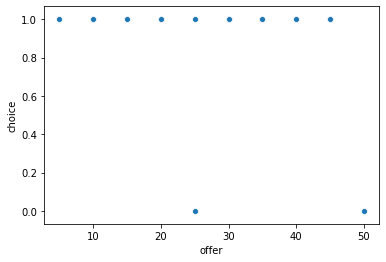

In [31]:
sns.scatterplot(x = 'offer', y = 'choice', data = df[df['sub'] == 62])

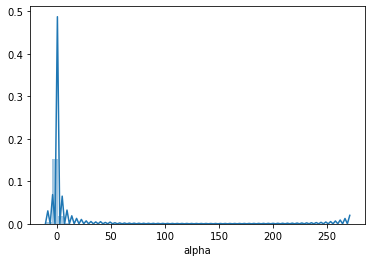

In [29]:
sns.distplot(df_results['alpha'])

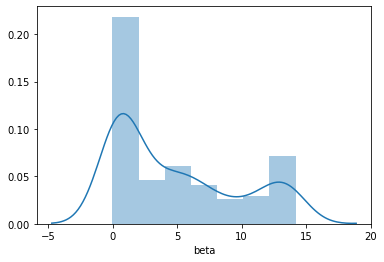

In [22]:
sns.distplot(df_results['beta'])

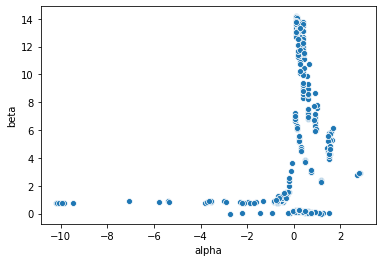

In [25]:
#sns.scatterplot(x = 'alpha', y = 'beta', data = df_results)

sns.scatterplot(x = 'alpha', y = 'beta', data = df_results[df_results['alpha']<10])